### Experimental Holography

TODO

In [1]:
# Header
# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('image', cmap='Blues')

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

# import slmsuite.hardware.slms.
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.cameras.alliedvision import AlliedVision

from slmsuite.hardware.cameraslms import FourierSLM

from slmsuite.holography import image_analysis

PySpin not installed. Install to use FLIR cameras.
Could not find thorlabs_tsi_sdk. Have you installed the Thorlabs Scientific Imaging SDK?
Install ThorCam and then extract the files in: ~\Program Files\Thorlabs\Scientific Imaging\Scientific Camera Support\Scientific_Camera_Interfaces.zip
Follow the instructions in Python_README.txt. Thorcam.configure_tlcam_dll_path() Error:
No module named 'thorlabs_tsi_sdk'


In [2]:
slm = Santec(slm_number=1, display_number=2, wav_um=.515, verbose=True)

Santec initializing... success
Looking for display... success
Opening LCOS-SLM,SOC,8001,2018021001... success


In [3]:
slm.load_flatmap('C:\\Users\\Experiment\\Documents\\GitHub\\qp-slm\\docs\\source\\Wavefront_correction_Data_211236000001(520nm).csv');

In [4]:
cam = AlliedVision(serial="02C5V", verbose=True, fliplr=True)

vimba initializing... success
Looking for cameras... success
vimba sn 02C5V initializing... success


In [9]:
fs = FourierSLM(cam, slm)

100%|██████████| 50/50 [00:00<00:00, 82.72it/s]


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
float64 uint16


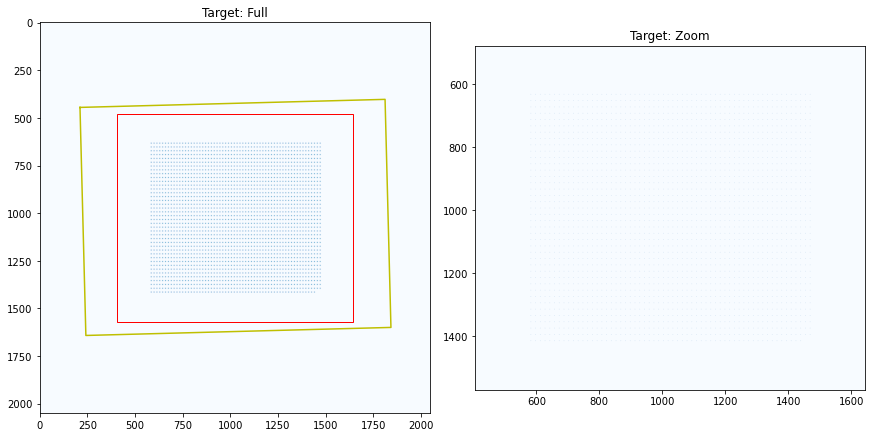

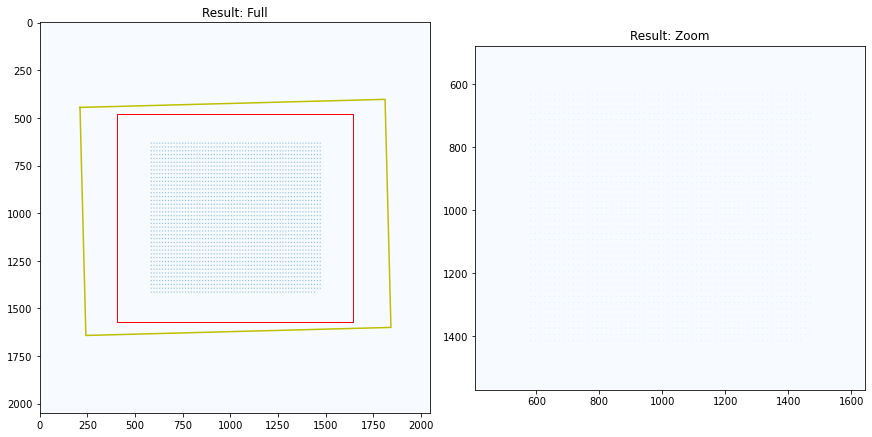

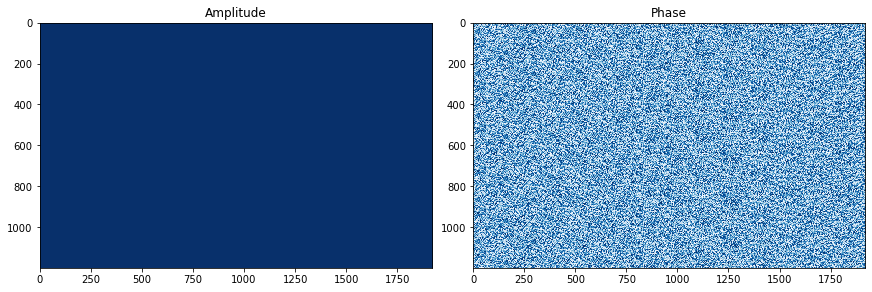

index 1088 is out of bounds for axis 0 with size 1088


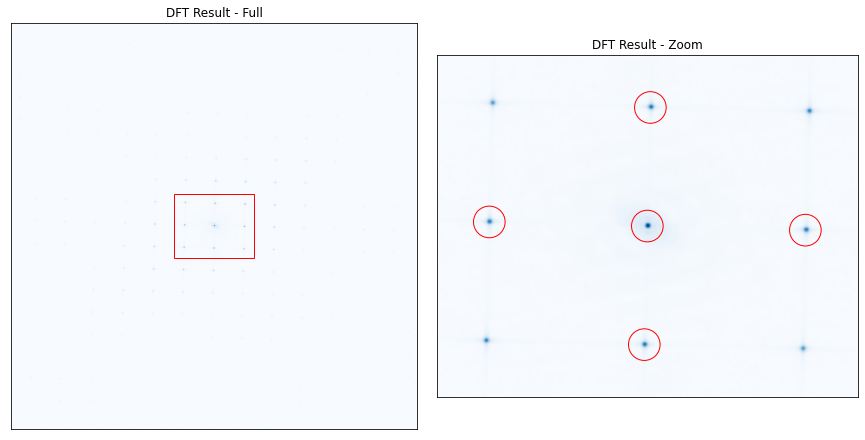

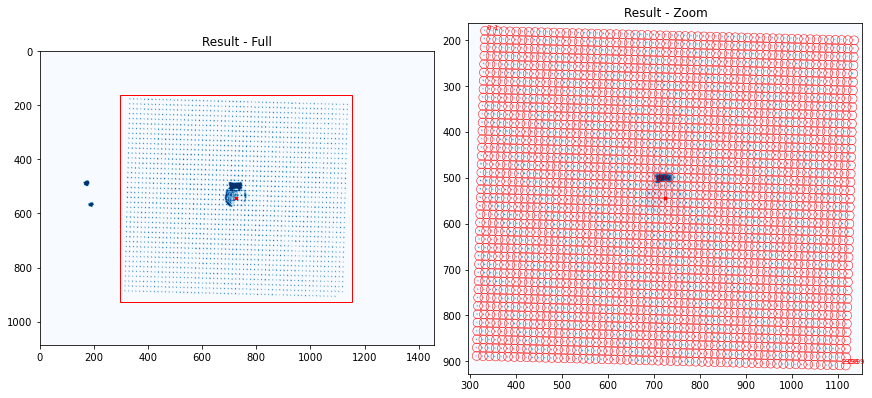

In [23]:
cam.set_exposure(5e-3)
fs.fourier_calibrate(array_shape=[60, 40], array_pitch=[15, 20])
# fs.fourier_calibrate(array_shape=[30, 20], array_pitch=[30, 40])
# fs.fourier_calibrate(array_shape=[18, 10], array_pitch=[60, 80])
cam.set_exposure(1e-3)

In [24]:
import time
import cv2
import scipy.ndimage as ndimage
import slmsuite.holography.lcos_toolbox as lcos_toolbox
import slmsuite.holography.image_analysis as image_analysis
from slmsuite.holography.algorithms import FeedbackHologram

In [26]:
lcos_toolbox.print_blaze_conversions([1,1], "deg", slm=fs.slm, shape=(2048, 2048))

'norm' : (0.017453292519943295, 0.017453292519943295)
'kxy' : (0.017453292519943295, 0.017453292519943295)
'rad' : (0.017453292519943295, 0.017453292519943295)
'knm' : (555.2519313529144, 555.2519313529144)
'freq' : (0.27111910710591525, 0.27111910710591525)
'lpmm' : (33.88988838823941, 33.88988838823941)
'mrad' : (17.453292519943297, 17.453292519943297)
'deg' : (1.0, 1.0)


'norm' : (0.01, 0.01)
'kxy' : (0.01, 0.01)
'rad' : (0.01, 0.01)
[[15.53398058]
 [15.53398058]]
nan
'knm' : (nan, nan)
'freq' : (0.1553398058252427, 0.1553398058252427)
'lpmm' : (19.41747572815534, 19.41747572815534)
'mrad' : (10.0, 10.0)
'deg' : (0.5729577951308232, 0.5729577951308232)


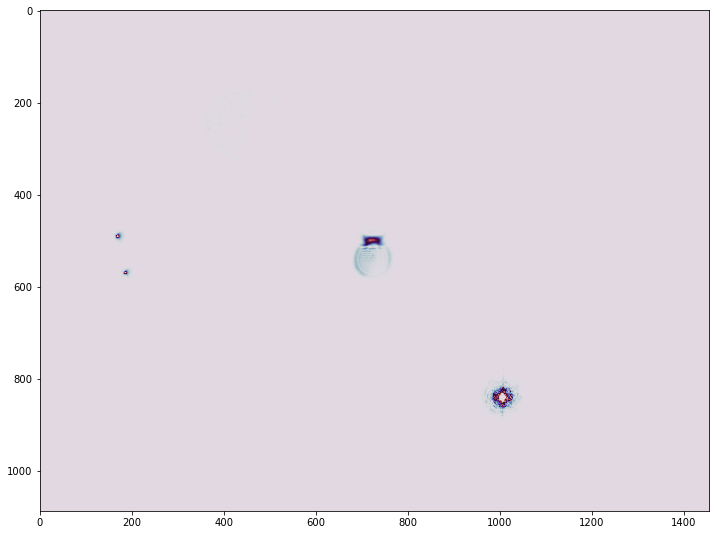

In [33]:
def blazeme(blaze_kxy):
    lcos_toolbox.print_blaze_conversions(blaze_kxy, "kxy", slm=fs.slm)

    fs.slm.write(None, blaze_vector=blaze_kxy)

    time.sleep(.3)

    img = fs.cam.get_image()

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.show()

blazeme([.01, .01])

[[0.00997594]
 [0.01536804]]
'norm' : (0.009975939052201701, 0.015368044201517578)
'kxy' : (0.009975939052201701, 0.015368044201517578)
'rad' : (0.009975939052201701, 0.015368044201517578)
[[15.53398058]
 [15.53398058]]
nan
'knm' : (nan, nan)
'freq' : (0.15496604352934681, 0.23872690021774878)
'lpmm' : (19.370755441168352, 29.840862527218597)
'mrad' : (9.975939052201701, 15.368044201517577)
'deg' : (0.5715792043708962, 0.8805240721174544)


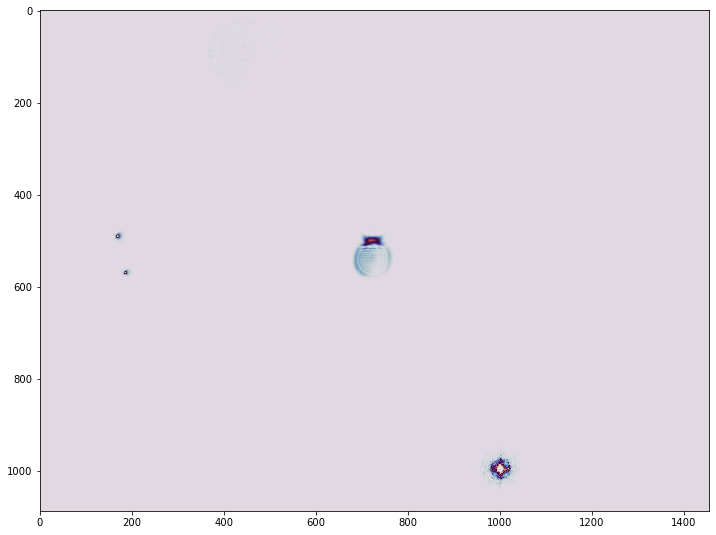

In [37]:
def blazeme(blaze_ij):
    blaze_kxy = fs.ijcam_to_kxyslm(blaze_ij)

    print(blaze_kxy)

    lcos_toolbox.print_blaze_conversions(blaze_kxy, "kxy", slm=fs.slm)

    fs.slm.write(None, blaze_vector=blaze_kxy)

    img = fs.cam.get_image()

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.show()

blazeme([1000, 1000])

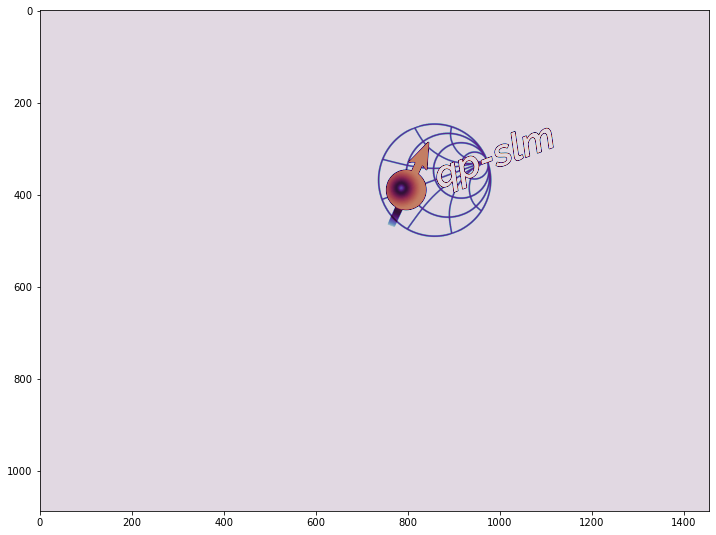

100%|██████████| 100/100 [00:01<00:00, 57.10it/s]


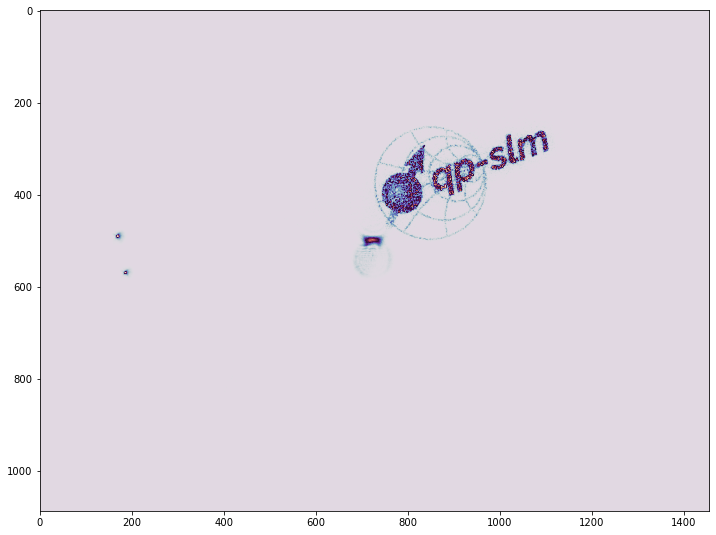

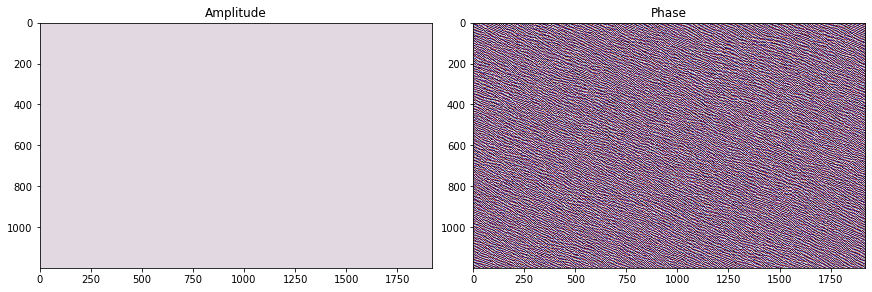

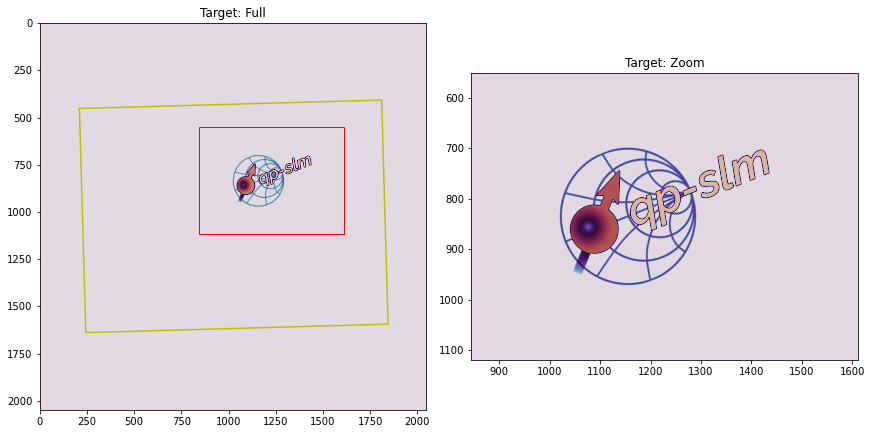

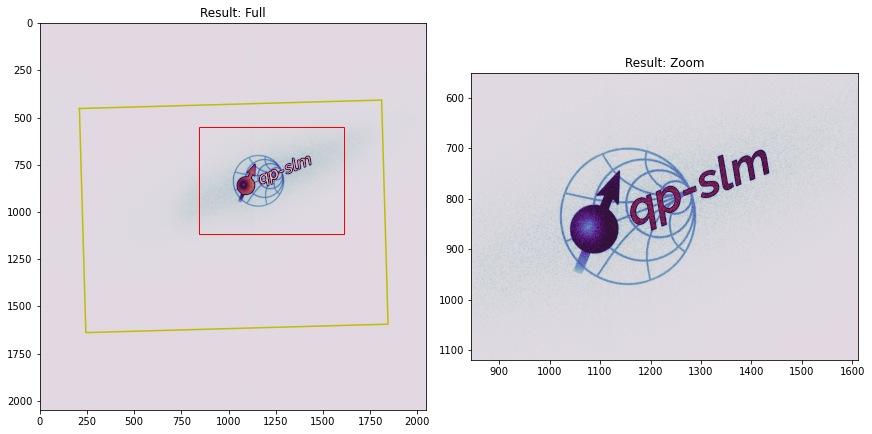

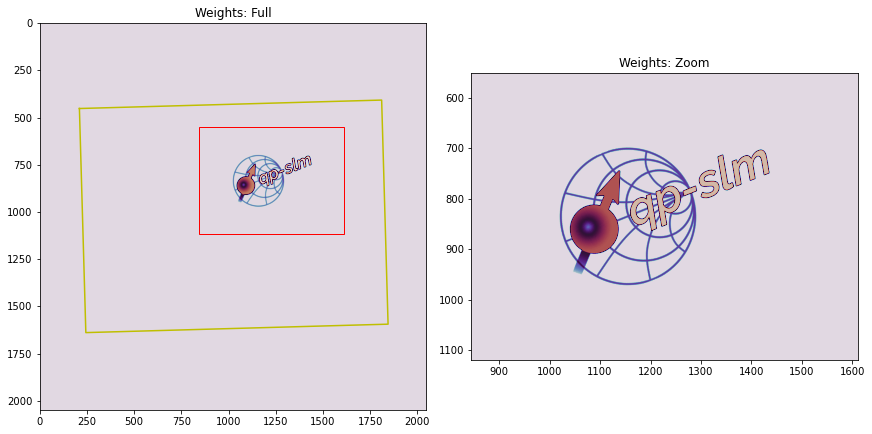

In [84]:
# Now lets try something other than spots, like a picture:
path = os.path.join(os.getcwd(), '../static/qp-slm-small.png')
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# This logo has white background, so we invert such that the field is dark.
img = cv2.bitwise_not(img)

img_amp = image_analysis.make8bit(np.sqrt(img))

# Resize (zero pad) for GS.
shape = (2048,2048)
target = lcos_toolbox.pad(img_amp, shape)

img_amp_rot = ndimage.rotate(img_amp, 20)
target_ij = lcos_toolbox.pad(img_amp_rot, fs.cam.shape) # + 10
target_ij = np.roll(target_ij, (-200, 200), axis=(0,1))

plt.figure(figsize=(12,12))
plt.imshow(target_ij)
plt.show()

# hologram = FeedbackHologram(target, cameraslm=fs)
hologram = FeedbackHologram(shape=shape, target=target_ij, cameraslm=fs)
# limits = hologram.plot_farfield() 
# hologram.plot_nearfield()

hologram.optimize(method="GS", maxiter=100, stat_groups=['computational'])

fs.slm.write(hologram.extract_phase())

time.sleep(1)

img = fs.cam.get_image()

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

hologram.plot_nearfield()
limits = hologram.plot_farfield()
hologram.plot_farfield(hologram.amp_ff, limits=limits, title='Result')
hologram.plot_farfield(hologram.weights, limits=limits, title='Weights');


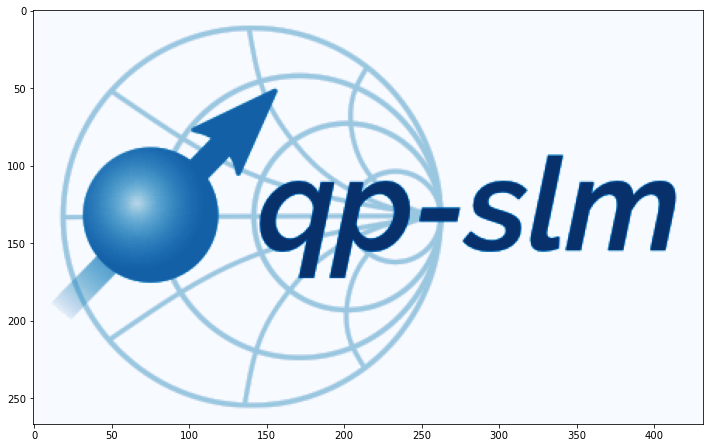

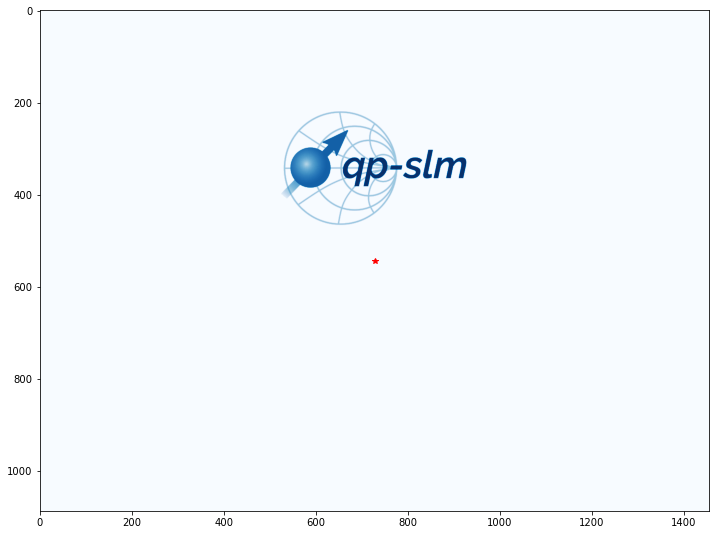

In [67]:
# Now lets try something other than spots, like a picture:
path = os.path.join(os.getcwd(), '../_static/qp-slm-small.png')
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# This logo has white background, so we invert such that the field is dark.
img = cv2.bitwise_not(img)

img_amp = image_analysis.make8bit(np.sqrt(img))
original_shape = img_amp.shape
target_shape = fs.cam.shape

# Resize (zero pad) for GS.
shape = (2048,2048)
target = lcos_toolbox.pad(img_amp, shape)

img_amp_rot = ndimage.rotate(img_amp, 0)
target_ij = lcos_toolbox.pad(img_amp_rot, fs.cam.shape) # + 10
target_ij = np.roll(target_ij, (-200, -0), axis=(0,1))

p = 10
cxi, cxf = int(-original_shape[1]/2 + target_shape[1]/2), int(original_shape[1]/2 + target_shape[1]/2)
cyi, cyf = int(-original_shape[0]/2 + target_shape[0]/2 - 200 - p), int(original_shape[0]/2 + target_shape[0]/2 - 200 + p)

final_images = {}
final_images["Target"] = target_ij[cyi:cyf, cxi:cxf]

plt.figure(figsize=(12,12))
plt.imshow(final_images["Target"])
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(target_ij)
plt.plot(target_ij.shape[1]/2, target_ij.shape[0]/2, 'r*')
plt.show()

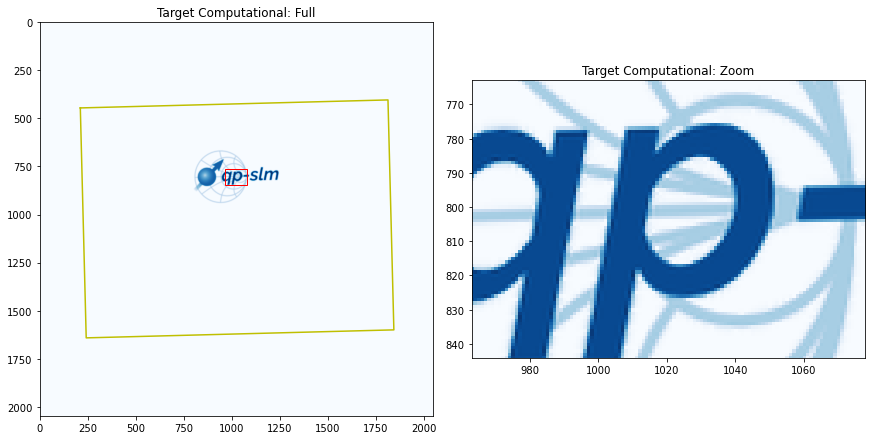

100%|██████████| 20/20 [00:00<00:00, 65.63it/s]


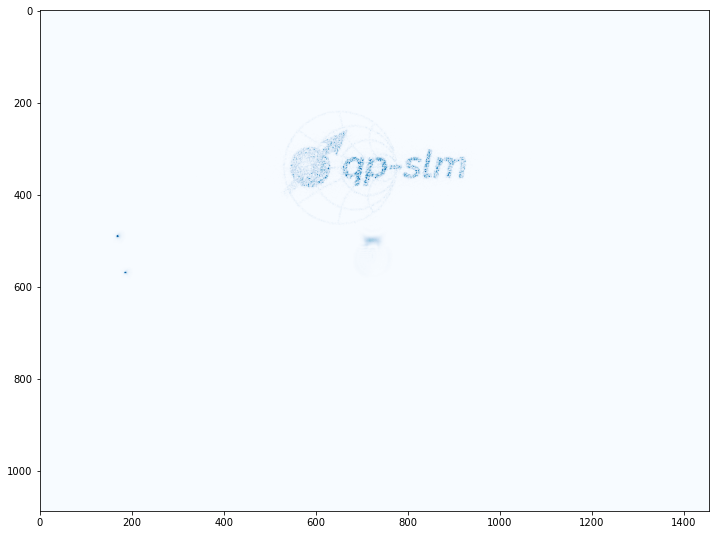

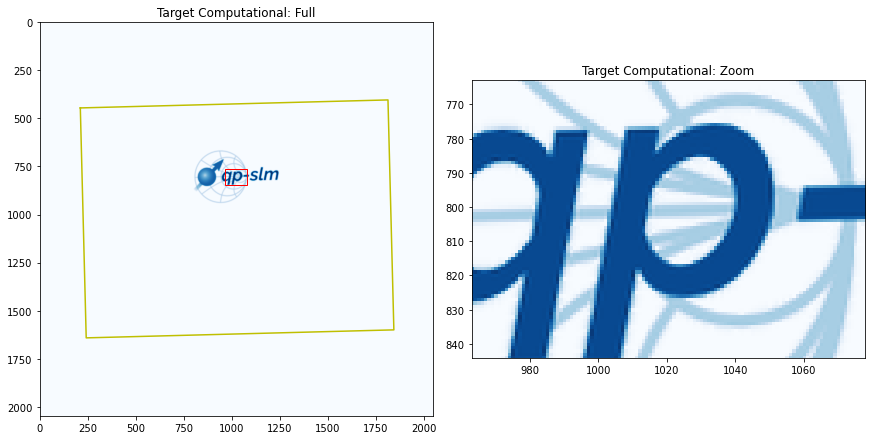

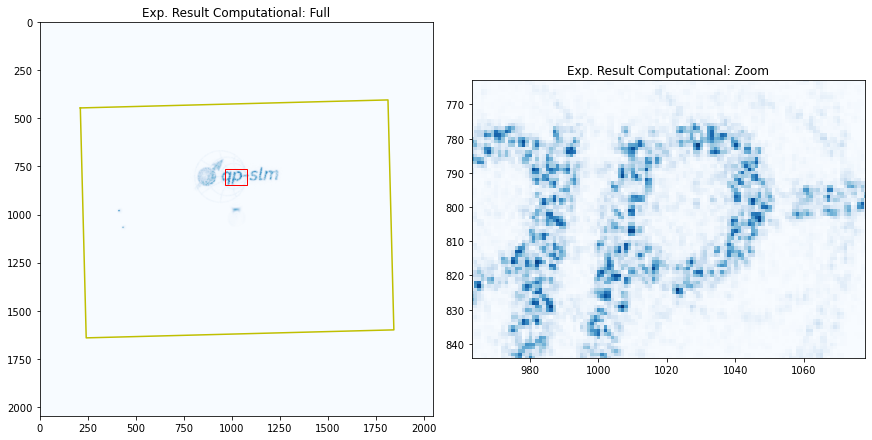

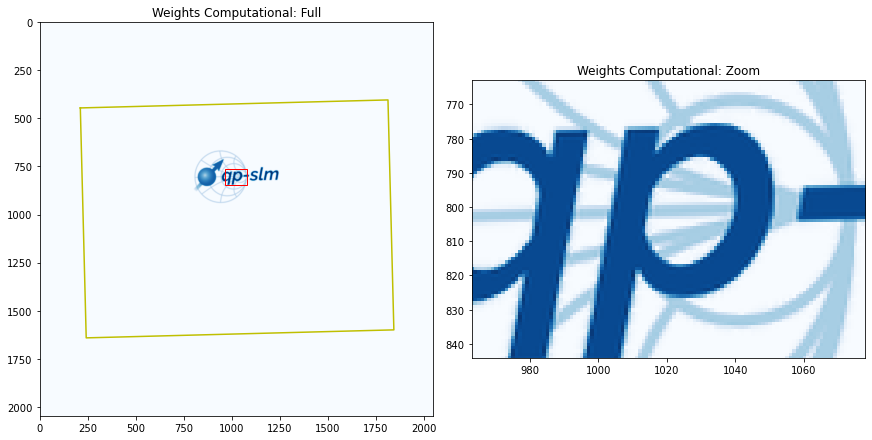

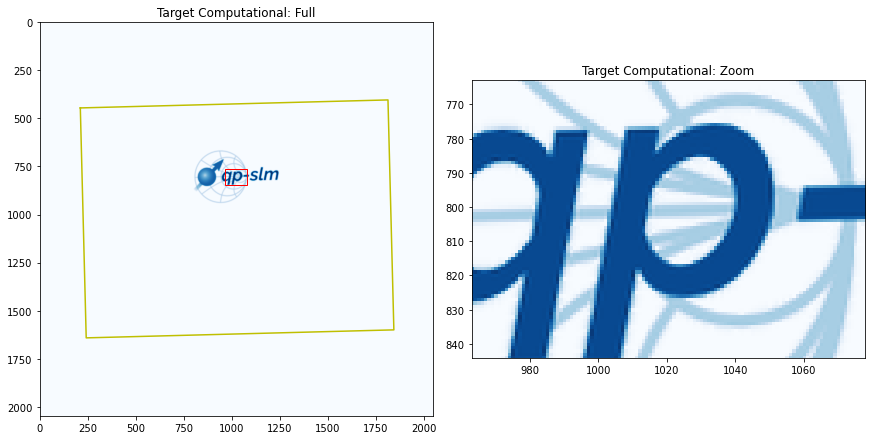

100%|██████████| 20/20 [00:00<00:00, 39.41it/s]


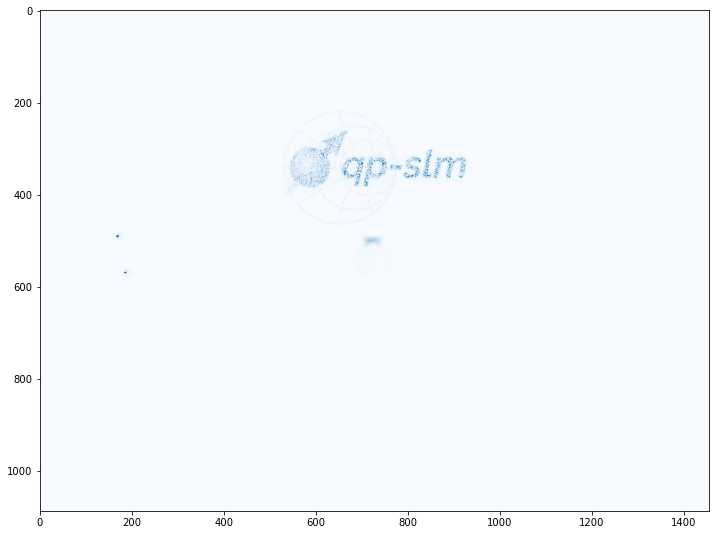

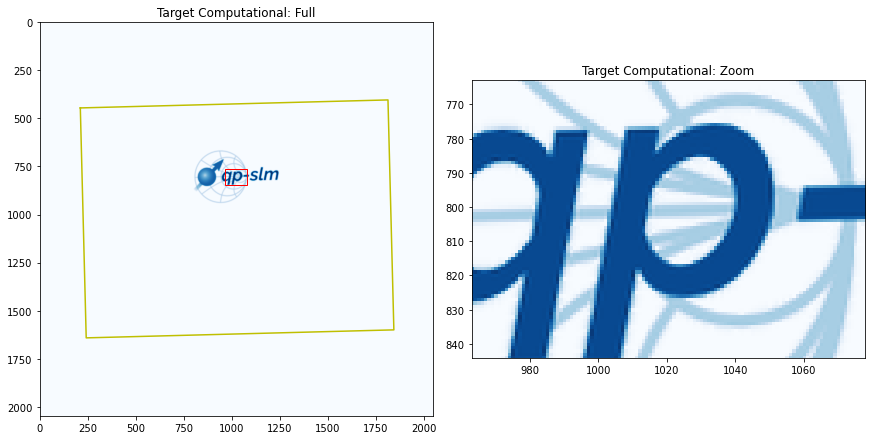

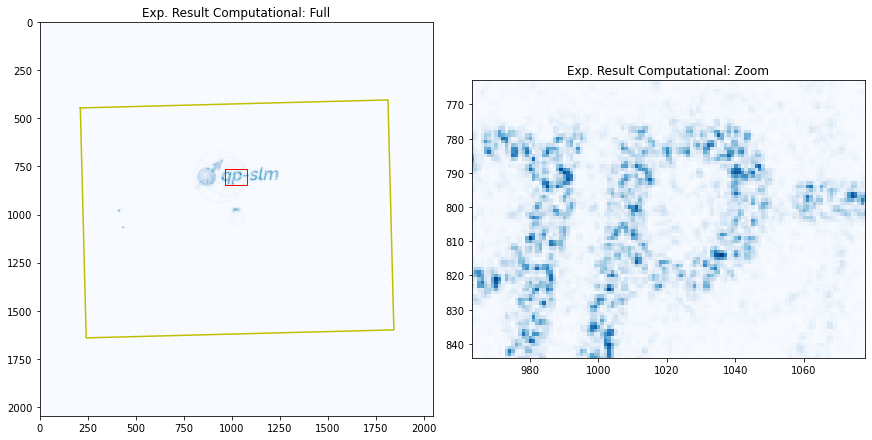

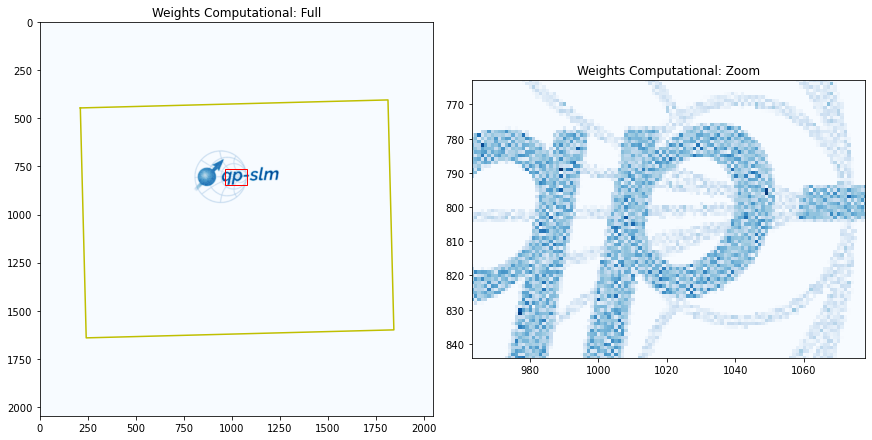

In [68]:
limits = None
def plot_data(title=' Computational'):
    fs.slm.write(hologram.extract_phase())

    time.sleep(.5)
    fs.cam.flush()
    img = fs.cam.get_image()

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.show()

    # hologram.plot_nearfield()
    limits = hologram.plot_farfield(title='Target' + title, limit_padding=-.4)
    # hologram.plot_farfield(hologram.amp_ff, limits=limits, title='Comp. Result' + title)
    hologram.plot_farfield(hologram.ijcam_to_knmslm(img).get(), limits=limits, title='Exp. Result' + title)
    # if hologram.img_knm is not None:
    #     hologram.plot_farfield(hologram.img_knm, limits=limits, title='Exp. Result After' + title)
    hologram.plot_farfield(hologram.weights, limits=limits, title='Weights' + title)

hologram = FeedbackHologram(shape=shape, target=target_ij, cameraslm=fs)

limits = hologram.plot_farfield(title='Target Computational', limit_padding=-.4)
hologram.optimize(method="GS", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational')

img = fs.cam.get_image()
final_images["GS"] = img[cyi:cyf, cxi:cxf]

hologram = FeedbackHologram(shape=shape, target=target_ij, cameraslm=fs)

limits = hologram.plot_farfield(title='Target Computational', limit_padding=-.4)
hologram.optimize(method="WGS-Kim", maxiter=20, feedback='computational', stat_groups=['computational'])
plot_data(title=' Computational')

img = fs.cam.get_image()
final_images["WGS-Computational"] = img[cyi:cyf, cxi:cxf]

# hologram.optimize(method="WGS-Kim", maxiter=2, feedback='experimental', stat_groups=['computational'])
# plot_data(title=' Experimental')
# hologram.optimize(method="WGS-Kim", maxiter=4, feedback='experimental', stat_groups=['computational'])
# plot_data(title=' Experimental')


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


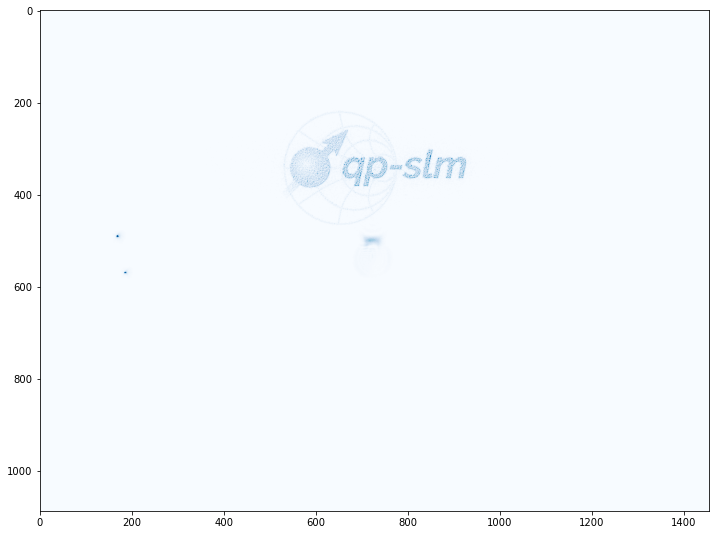

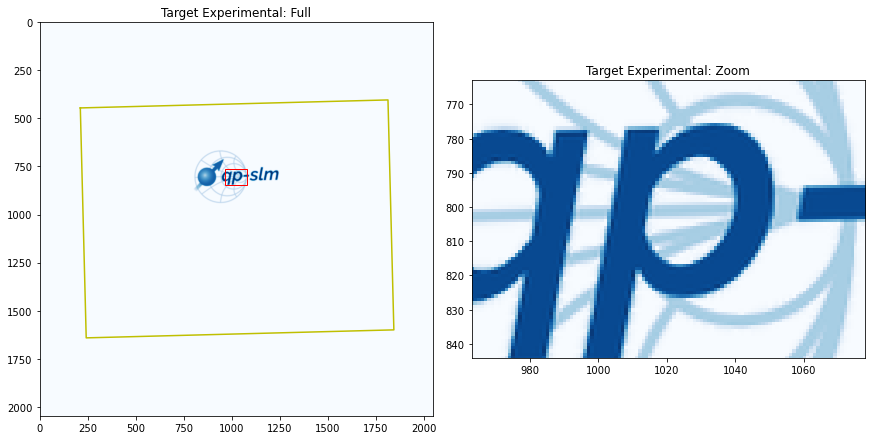

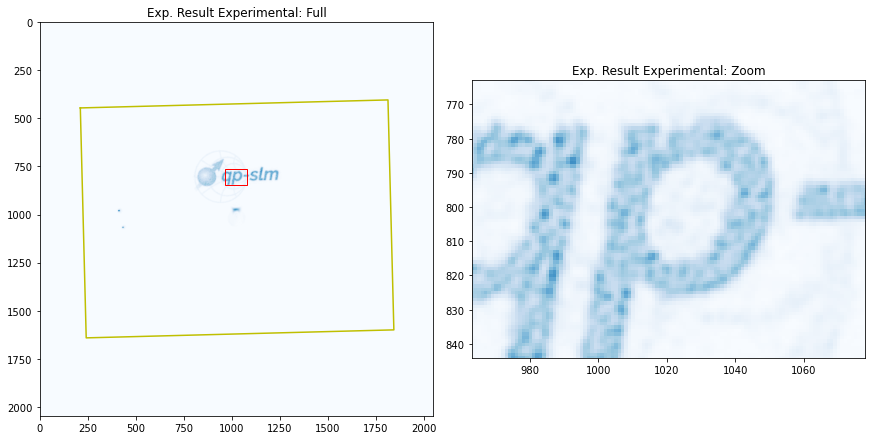

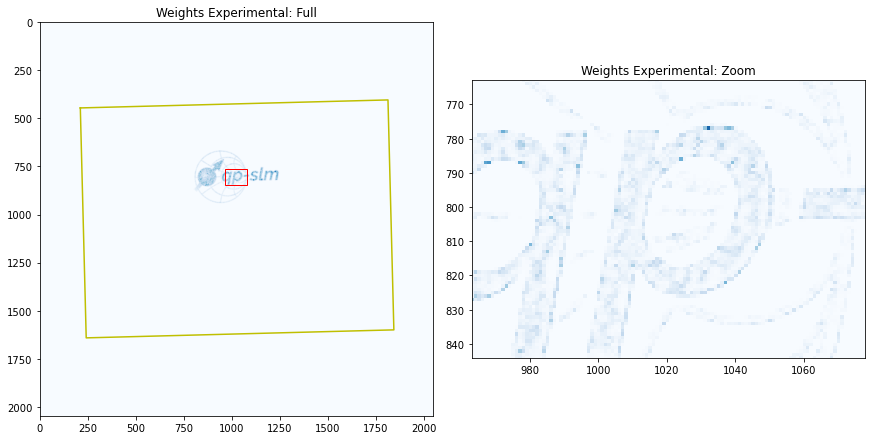

In [69]:
def opt():
    hologram.optimize(method="WGS-Kim", maxiter=20, feedback='experimental', 
    stat_groups=['computational', 'experimental'], blur_ij=1)

opt()
plot_data(title=' Experimental')

img = fs.cam.get_image()
final_images["WGS-Experimental"] = img[cyi:cyf, cxi:cxf]

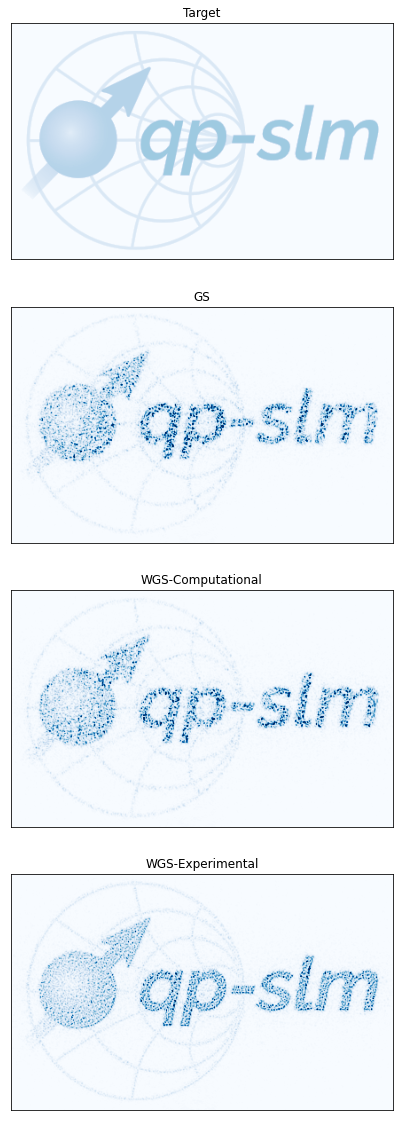

In [78]:
fig, axs = plt.subplots(4, 1, figsize=(20,20))

maxes = []

for x, key in enumerate(final_images.keys()):
    final_images[key] = final_images[key].astype(np.float64)
    final_images[key] *= 1/np.mean(final_images[key])
    maxes.append(np.amax(final_images[key]))

max = np.max(maxes) * .75

for x, key in enumerate(final_images.keys()):
    axs[x].imshow(final_images[key], vmin=0, vmax=max)
    axs[x].set_title(key)
    axs[x].xaxis.set_visible(False)
    axs[x].yaxis.set_visible(False)

In [315]:
def test_ijcam_to_knmslm():
    img = fs.cam.get_image()
    hologram.ijcam_to_knmslm(img, blur=2)

%lprun -f FeedbackHologram.ijcam_to_knmslm test_ijcam_to_knmslm()

Timer unit: 1e-07 s

Total time: 0.0661642 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\..\..\slmsuite\holography\algorithms.py
Function: ijcam_to_knmslm at line 1187

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1187                                               def ijcam_to_knmslm(self, img, output=None, blur=0):
  1188                                                   """
  1189                                                   Convert an image in the camera domain to computational SLM k-space using, in part, the
  1190                                                   affine transformation stored in a cameraslm's Fourier calibration.
  1191                                           
  1192                                                   Note
  1193                                                   ~~~~~~~~
  1194                                                   This includes two transformations: TODO: fix
  1195                           

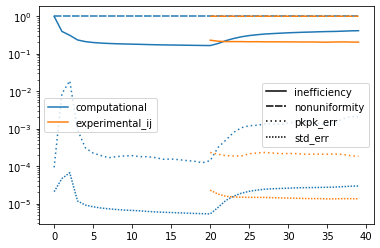

In [79]:
hologram.plot_stats()

In [254]:
phase = hologram.extract_phase()
def writetest():
    for x in range(100):
        fs.slm.write(phase)

%lprun -f Santec._phase2gray writetest()

Timer unit: 1e-07 s

Total time: 1.83621 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\..\..\slmsuite\hardware\slms\SLM.py
Function: _phase2gray at line 195

Line #      Hits         Time  Per Hit   % Time  Line Contents
   195                                               def _phase2gray(self, phase, out=None):
   196                                                   """
   197                                                   Helper function to convert an array of phases (units of 2pi) to an array of
   198                                                   :attr:`bitresolution` -scaled and -cropped integers. Note that, we add a minus sign to convert
   199                                                   between the 'increasing value ==> increasing voltage (= decreasing phase delay)' convention
   200                                                   in most SLMs and our 'increasing value ==> increasing phase delay' convention.
   201                             

In [261]:
phase = hologram.extract_phase()
def writetest():
    for x in range(100):
        fs.slm.write(phase)

%lprun -f Santec._phase2gray writetest()

Timer unit: 1e-07 s

Total time: 1.68211 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\..\..\slmsuite\hardware\slms\SLM.py
Function: _phase2gray at line 195

Line #      Hits         Time  Per Hit   % Time  Line Contents
   195                                               def _phase2gray(self, phase, out=None):
   196                                                   """
   197                                                   Helper function to convert an array of phases (units of 2pi) to an array of
   198                                                   :attr:`bitresolution` -scaled and -cropped integers. Note that, we add a minus sign to convert
   199                                                   between the 'increasing value ==> increasing voltage (= decreasing phase delay)' convention
   200                                                   in most SLMs and our 'increasing value ==> increasing phase delay' convention.
   201                             

In [271]:
phase = hologram.extract_phase()
def writetest():
    for x in range(100):
        fs.slm.write(phase)

%lprun -f Santec.write writetest()

Timer unit: 1e-07 s

Total time: 2.78067 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\..\..\slmsuite\hardware\slms\SLM.py
Function: write at line 142

Line #      Hits         Time  Per Hit   % Time  Line Contents
   142                                               def write(self, data, flatmap=True, phase_correct=True, wait_for_settle=False, blaze_vector=[0,0]):
   143                                                   """
   144                                                   Checks, cleans, and adds to data, then calls :meth:`._write_hw()` and potentially waits for settle.
   145                                           
   146                                                   Parameters
   147                                                   ----------
   148                                                   data : numpy.ndarray, None
   149                                                       Data to display. In units of phase delay. Data must be larger t

In [ ]:
phase = hologram.extract_phase()
def writetest():
    for x in range(100):
        fs.slm.write(phase)

%lprun -f Santec._phase2gray writetest()

Timer unit: 1e-07 s

Total time: 0.635114 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\..\..\slmsuite\hardware\slms\SLM.py
Function: _phase2gray at line 195

Line #      Hits         Time  Per Hit   % Time  Line Contents
   195                                               def _phase2gray(self, phase, out=None):
   196                                                   """
   197                                                   Helper function to convert an array of phases (units of 2pi) to an array of
   198                                                   :attr:`bitresolution` -scaled and -cropped integers. Note that, we add a minus sign to convert
   199                                                   between the 'increasing value ==> increasing voltage (= decreasing phase delay)' convention
   200                                                   in most SLMs and our 'increasing value ==> increasing phase delay' convention.
   201                            

In [266]:
x = np.array([-100], dtype=np.uint16)

In [267]:
np.bitwise_and(x, 255)

array([156], dtype=uint16)

In [269]:
slm.display = None

In [252]:
phase = hologram.extract_phase()
def writetest():
    fs.slm.write(phase)

%lprun -f Santec._phase2gray writetest()

Timer unit: 1e-07 s

Total time: 0.164425 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\..\..\slmsuite\hardware\slms\SLM.py
Function: _phase2gray at line 195

Line #      Hits         Time  Per Hit   % Time  Line Contents
   195                                               def _phase2gray(self, phase, out=None):
   196                                                   """
   197                                                   Helper function to convert an array of phases (units of 2pi) to an array of
   198                                                   :attr:`bitresolution` -scaled and -cropped integers. Note that, we add a minus sign to convert
   199                                                   between the 'increasing value ==> increasing voltage (= decreasing phase delay)' convention
   200                                                   in most SLMs and our 'increasing value ==> increasing phase delay' convention.
   201                            

In [236]:
%load_ext snakeviz
%load_ext line_profiler

In [107]:
from slmsuite.holography.algorithms import SpotHologram

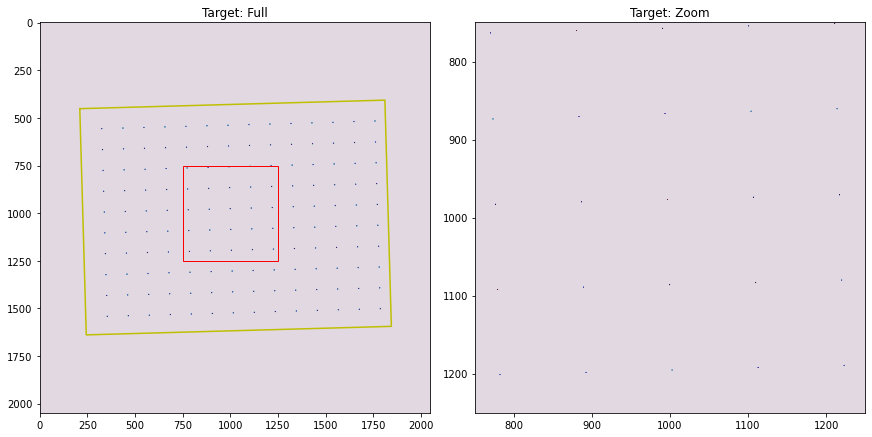

In [114]:
shape = (2048, 2048)
cam_shape = np.array(fs.cam.shape)

xlist = np.arange(100, cam_shape[1], 100)
ylist = np.arange(100, cam_shape[0], 100)

xgrid, ygrid = np.meshgrid(xlist, ylist)

hologram = SpotHologram(shape, xgrid, ygrid, basis='ij', cameraslm=fs)

hologram.plot_farfield(limits=[[750, 1250], [750, 1250]]);

100%|██████████| 100/100 [00:01<00:00, 62.56it/s]


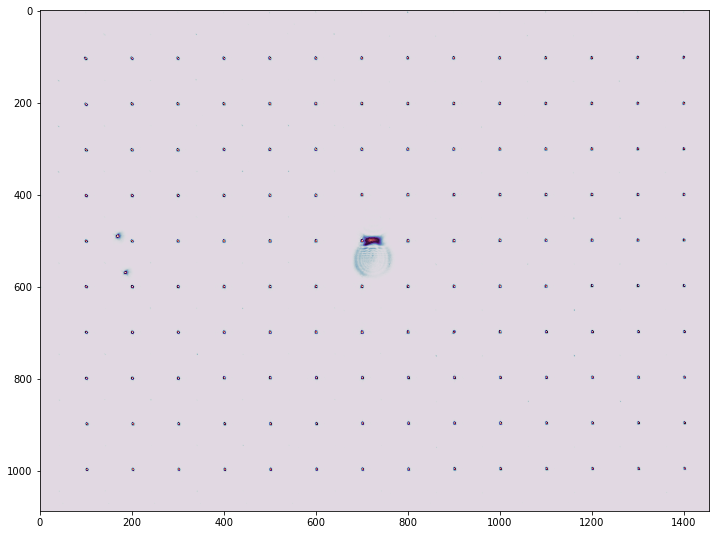

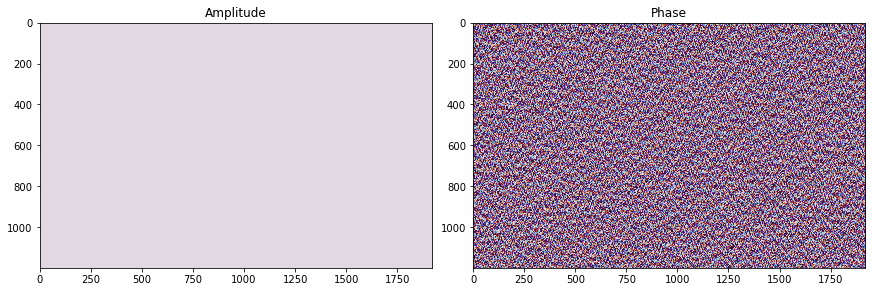

In [115]:
hologram.optimize('WGS-Kim', maxiter=100)

fs.slm.write(hologram.extract_phase())

fs.cam.flush()
img = fs.cam.get_image()

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

hologram.plot_nearfield()

In [10]:
exposure_s = cam.autoexposure(.5, bounds_s=[200e-6, 1e-3])
print("Exposure: {} us".format(exposure_s*1e6))

0.0005017780705882353 255.0
0.0002518729138638985 204.0
0.0002 153.0
0.0002 153.0
0.0002 102.0
0.00025098039215686274 51.0
0.0005019607843137255 102.0
0.000629911572472126 153.0
Exposure: 629.9115724721261 us


In [ ]:
img = cam.get_image()

In [ ]:
for rot in range(4):
    for flip in range(2):
        print(rot, flip)
        transform = image_analysis.get_transform(rot=rot, fliplr=flip, flipud=False)
        orientation = image_analysis.blob_array_detect(transform(img), [15,10], plot=True)

0.0038082420000000003 50.52
0.007616484000000001 102.4
0.009520605 128.84


c:\Users\Experiment\Documents\GitHub\qp-slm\docs\source\..\..\slmsuite\hardware\CameraSLM.py:545: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img+1), cmap='Blues')


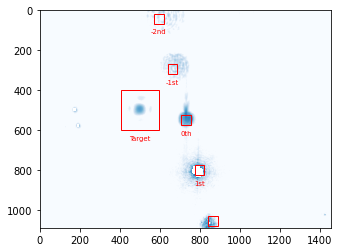

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


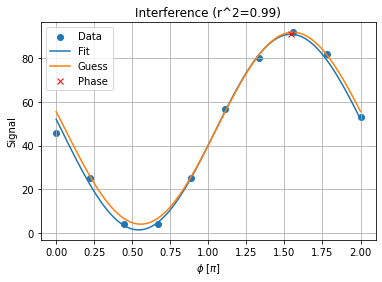

In [24]:
fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(15,15), autoexposure=True)

In [ ]:
data = fs.wavefront_calibrate((500, 500), (800, 800), autoexposure=True, plot=0)

0.0034258580000000004 50.12
0.006851716000000001 102.32000000000001
0.008571341360437842 127.96000000000001


c:\Users\Experiment\Documents\GitHub\qp-slm\docs\source\..\..\slmsuite\hardware\CameraSLM.py:545: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img+1), cmap='Blues')


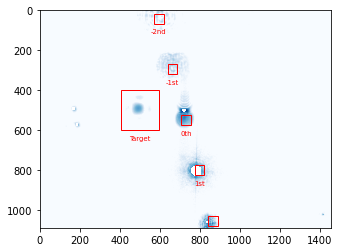

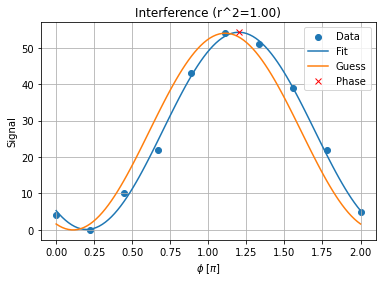

{'amplitude': 13868, 'normalization': 24216, 'phase': 3.7696436942326548, 'kx': array([-9.92975889]), 'ky': array([-14.46097054]), 'amp_fit': 54.142279827246945, 'contrast_fit': 0.9977997941540075, 'r2_fit': 0.9956397330288357}


In [85]:
fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(15,15), autoexposure=True)

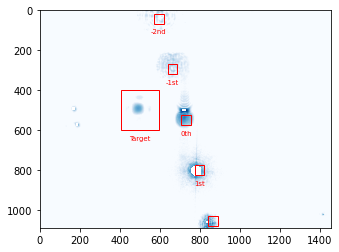

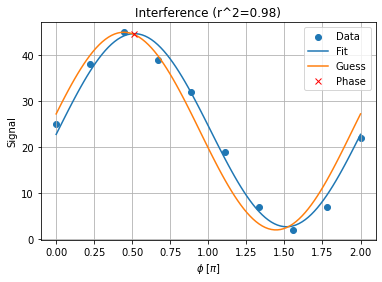

{'amplitude': 9621, 'normalization': 24257, 'phase': 1.6139297831208943, 'kx': array([-5.87750484]), 'ky': array([-11.77458617]), 'amp_fit': 42.00894994813325, 'contrast_fit': 0.9399016953668892, 'r2_fit': 0.9849653613895472}


In [92]:
print(fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(21,20), autoexposure=False))
print(fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(0,0), autoexposure=False))
print(fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(5,5), autoexposure=False))
print(fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(10,10), autoexposure=False))
print(fs.wavefront_calibrate((500, 500), (800, 800), test_interference=(25,25), autoexposure=False))

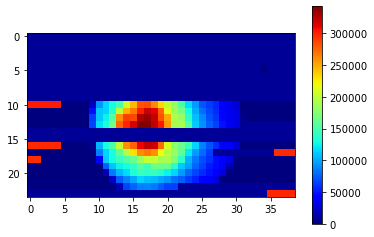

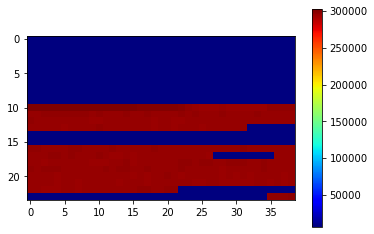

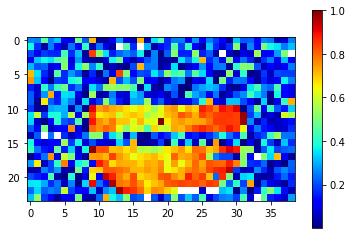

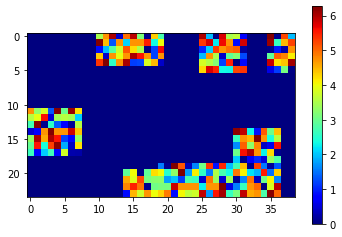

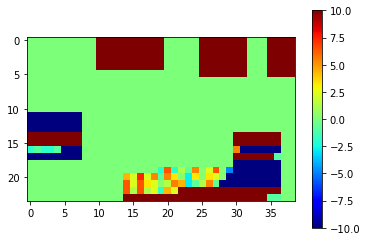

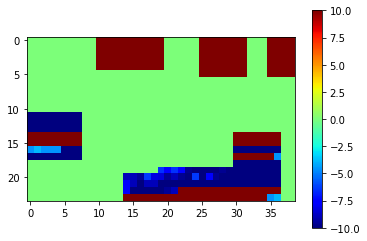

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Experiment\.conda\envs\qp-slm\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Experiment\AppData\Local\Temp\ipykernel_3140\1832559725.py", line 1, in <cell line: 1>
    fs.process_wavefront_calibration()
  File "c:\Users\Experiment\Documents\GitHub\qp-slm\docs\source\..\..\slmsuite\hardware\CameraSLM.py", line 831, in process_wavefront_calibration
    imprint(phase, np.array([nxref, 1, nyref, 1]) * superpixel_size,
  File "c:\Users\Experiment\Documents\GitHub\qp-slm\docs\source\..\..\slmsuite\holography\lcos_toolbox.py", line 82, in imprint
    matrix[yi:yf,xi:xf] = function((x_grid[yi:yf,xi:xf], y_grid[yi:yf,xi:xf]), **kwargs)
  File "c:\Users\Experiment\Documents\GitHub\qp-slm\docs\source\..\..\slmsuite\holography\lcos_toolbox.py", line 137, in blaze
    return 2 * np.pi * (vector[0]*x_grid + vector[1]*y_grid) + offset
ValueError: oper

In [93]:
fs.process_wavefront_calibration()

In [75]:
fs.wavefront_calibration_raw.keys()

dict_keys(['NX', 'NY', 'nxref', 'nyref', 'superpixel_size', 'interference_point', 'interference_size', 'amplitude', 'normalization', 'phase', 'kx', 'ky', 'amp_fit', 'contrast_fit', 'r2_fit'])

In [27]:
import tqdm, time

In [43]:
for x in tqdm.tqdm(range(4), desc="x", position=1, leave=True):
    for y in tqdm.tqdm(range(4), desc="y", position=0, leave=False):
        time.sleep(.1)

x: 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


In [69]:
for x in tqdm.tqdm(range(4), desc="x", position=0, leave=False):
    time.sleep(1)
    for y in tqdm.tqdm(range(10), desc="y", position=0, leave=False):
        time.sleep(.1)

KeyboardInterrupt: 

In [70]:
for x in tqdm.tqdm(range(4), desc="x"):
    time.sleep(1)
    for y in tqdm.tqdm(range(10), desc="y"):
        time.sleep(.1)

x:  75%|███████▌  | 3/4 [00:07<00:02,  2.45s/it]


KeyboardInterrupt: 

In [15]:
True == 1

True

In [ ]:
fs.slm.settle_time_s

In [ ]:
cam.get_properties()

In [ ]:
am = cam.cam.AcquisitionMode.set('SingleFrame')

In [ ]:
for e in am.get_available_entries():
    print(e)

In [ ]:
ac.get()

In [ ]:
e = cam.cam.TriggerSource.get_available_entries()[0]

In [ ]:
for e in cam.cam.TriggerMode.get_available_entries():
    print(e) 

In [ ]:
fs.cam.close()

In [95]:
fs.cam = AlliedVision(serial="", verbose=True, fliplr=True)
cam = fs.cam

vimba initializing... success
Looking for cameras... success
No serial given... Choosing first of  ['02C5V', '08-406808001844']
vimba sn 02C5V initializing... success


In [ ]:
frame = cam.cam.get_frame(timeout_ms=1000)

In [ ]:
cam.cam.AcquisitionMode.set('Continuous')
cam.cam.AcquisitionStart.run()

In [113]:
cam.cam.TriggerMode.set('Off')

In [115]:
str(cam.cam.TriggerMode.get())

'Off'

In [100]:
cam.cam.TriggerSelector.set('FrameStart')
cam.cam.TriggerMode.set('On')
cam.cam.AcquisitionStart.run()

In [99]:
cam.cam.AcquisitionStatus.get()

False

In [98]:
cam.cam.AcquisitionStop.run()

In [105]:
cam.cam.TriggerSoftware.run()

In [108]:
g = cam.cam.get_frame_generator()

In [112]:
g.close()

In [104]:
frame = cam.cam.get_frame(timeout_ms=100)

VimbaTimeout: Frame capturing on Camera 'DEV_1AB22C01AA13' timed out.

In [ ]:
cam.flush(1e-2)

In [ ]:
cam.cam.TriggerMode.set('Off')

In [ ]:
cam.cam.AcquisitionStart.run()

In [ ]:
cam.get_exposure()

In [ ]:
cam.get_exposure()

In [ ]:
trig = cam.cam.TriggerSoftware

In [ ]:
trig.run()

In [ ]:
cam.set_exposure(.002)

In [ ]:
img = cam.get_image()

In [ ]:
fs.cam = AlliedVision()

In [ ]:
cam = fs.cam

In [ ]:
cam.flush(2e-2)

In [94]:
cam.close()

In [ ]:
masked = img[450:550, 450:550]
masked2 = img[400:600, 400:600]

In [ ]:
plt.imshow(masked2)

In [ ]:
len(masked2.ravel())

In [ ]:
import cv2, time

In [ ]:
blur = 51

masked3 = image_analysis.make8bit(masked2)

t = time.perf_counter()
masked3 = cv2.GaussianBlur(masked3, (blur, blur), 0)
print(time.perf_counter() - t)


plt.imshow(masked3)

In [ ]:
_, max_val, _, max_loc = cv2.minMaxLoc(masked3)
print(max_val, max_loc)

In [ ]:
edge_x = np.arange(-100, 100) + .5
edge_y = np.arange(-100, 100) + .5

region_x, region_y = np.meshgrid(edge_x, edge_y)

def sinc2(mesh, a, cx, cy, w):
    return a * np.square(np.sinc((mesh[0] - cx) / w) * np.sinc((mesh[1] - cy) / w))

plt.imshow(sinc2((region_x, region_y), 1, 0, 0, 40)); plt.show()

In [ ]:
from scipy import optimize

In [ ]:
ps, _ = optimize.curve_fit(sinc2, (region_x.ravel(), region_y.ravel()), masked2.ravel(), p0=[np.amax(masked2), 0, 0, 40])

In [ ]:

plt.imshow(sinc2((region_x, region_y), *ps)); plt.show()
plt.imshow(masked2); plt.show()

In [ ]:
test = [1, 2, np.nan]

np.sum(test)

test[np.nan]

In [ ]:
plt.figure(figsize=(20,15))
plt.imshow(slm.display)

In [ ]:
img = cam.get_image()
plt.figure(figsize=(20,15))
plt.imshow(np.log10(img+1), cmap='jet')

In [ ]:
print(fs)

In [ ]:
print(fs.__dict__)